In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import sys
import glob
import time
import tqdm
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
DATA_DIR = '../Data/'

In [11]:
from sklearn.model_selection import train_test_split
train = pd.read_csv(DATA_DIR+'plasticc_train_lightcurves.csv')
train_meta = pd.read_csv(DATA_DIR+'plasticc_train_metadata.csv')

test_meta = train_meta[-1000:]
test = train[-1000:]
train = train[:-1000]
train_meta = train_meta[:-1000]

train_meta.shape, test_meta.shape

((6848, 26), (1000, 26))

In [12]:
target = train_meta['target'].values.copy()
labels2weight = {x:1 for x in np.unique(target)}
train_mask = train_meta['distmod'].isnull().values #galactic
test_mask  = test_meta['distmod'].isnull().values

labels2weight[15] = 2
labels2weight[64] = 2
labels2weight[99] = 2

import collections
target2y = dict(map(reversed, enumerate(np.unique(target))))
y2target = dict(enumerate(np.unique(target)))
y = np.array(list(map(target2y.get, target)))
class_weight = np.array(list(map(lambda x: labels2weight[y2target[x]], sorted(np.unique(y)))))
y_cntr = collections.Counter(y)
wtable = np.array([y_cntr[i] for i in sorted(np.unique(y))]) / len(y)

print(sorted(np.unique(y)))
print(wtable)
print(class_weight)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.01796145 0.05826519 0.11565421 0.15405958 0.02321846 0.0036507
 0.0635222  0.0119743  0.12573014 0.0265771  0.04731308 0.29906542
 0.03081192 0.02219626]
[1 2 1 1 1 1 1 2 1 1 1 1 1 1]


In [15]:
from sklearn.model_selection import StratifiedKFold as KFold
nfolds = 5
kf = KFold(n_splits=nfolds, shuffle=True, random_state=42)
cv_folds = np.arange(len(target))
for i,_ in enumerate(kf.split(train_meta, target)):
    cv_folds[_[1]] = i
evals = pd.DataFrame()
evals['object_id'] = train_meta['object_id']
evals['target'] = target
evals['cv_folds'] = cv_folds
evals['is_gal'] = train_mask.astype('int')
evals['is_ddf'] = train_meta['ddf_bool'].values
evals.to_csv('evals.csv', index=False)

In [16]:
remove_cols = ['hostgal_specz', 'target']
for c in remove_cols:
    if c in train_meta.columns:
        del train_meta[c]
    if c in test_meta.columns:
        del test_meta[c]

In [17]:
train_meta['distmod'].fillna(0, inplace=True)
test_meta['distmod'].fillna(0, inplace=True)

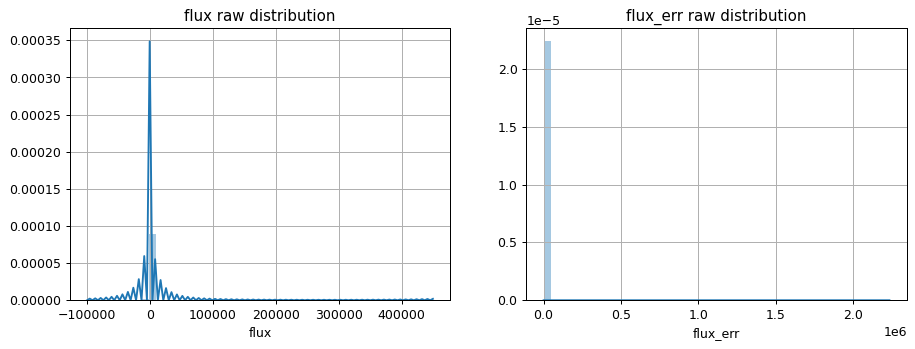

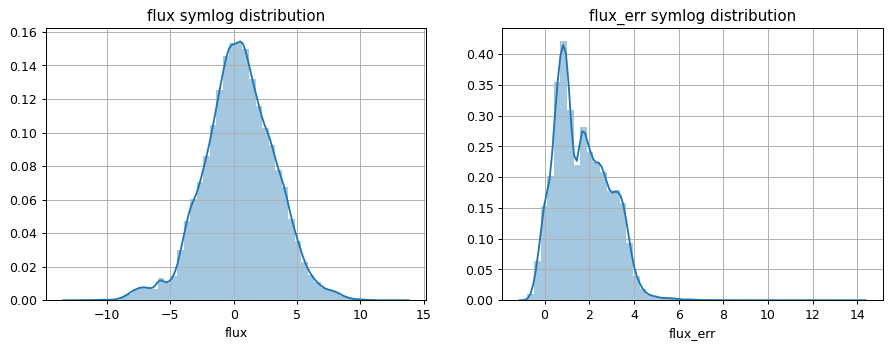

In [18]:
plt.figure(figsize=[12, 4], dpi=90)
plt.subplot(1, 2, 1)
sns.distplot(train['flux'].sample(frac=0.1))
plt.title('flux raw distribution')
plt.grid()
plt.subplot(1, 2, 2)
sns.distplot(train['flux_err'].sample(frac=0.1))
plt.title('flux_err raw distribution')
plt.grid();

plt.figure(figsize=[12, 4], dpi=90)
plt.subplot(1, 2, 1)
sns.distplot(train['flux'].sample(frac=0.1).apply(lambda x: np.sign(x) * np.log(np.abs(x))))
plt.title('flux symlog distribution')
plt.grid()
plt.subplot(1, 2, 2)
sns.distplot(train['flux_err'].sample(frac=0.1).apply(lambda x: np.sign(x) * np.log(np.abs(x))))
plt.title('flux_err symlog distribution')
plt.grid();

In [19]:
for c in ['flux', 'flux_err']: 
    train[c] = train[c].apply(lambda x: np.sign(x) * np.log(np.abs(x)))
c = 'mjd'
train[c] = (train[c] - train[c].mean()) / train[c].std()

In [20]:
%%time
train = train.groupby(['object_id', 'passband']).apply(
    lambda x: x.set_index(['object_id', 'passband']).to_dict(orient='list')
)
train.to_pickle('train_ts.pkl')

CPU times: user 1min 4s, sys: 235 ms, total: 1min 4s
Wall time: 1min 4s


In [64]:
print(train.loc[615, 1].keys())
train.to_frame().head(15)

dict_keys(['mjd', 'flux', 'flux_err', 'detected_bool'])


0
object_id passband                                                   
615       0         {'mjd': [-1.1642993036781029, -1.1612224470376...
          1         {'mjd': [-1.38652693180034, -1.380110966208851...
          2         {'mjd': [-1.3865518312182459, -1.3801358656267...
          3         {'mjd': [-1.3865020323824342, -1.3800860667909...
          4         {'mjd': [-1.3864803666551773, -1.3800504961939...
          5         {'mjd': [-1.3800178359185256, -1.3318655953914...
713       0         {'mjd': [-1.0606679263803354, -0.9864204491564...
          1         {'mjd': [-1.1445272256515109, -1.0993978391313...
          2         {'mjd': [-1.1445518017003375, -1.0994220918110...
          3         {'mjd': [-1.144502649602684, -1.09937293971339...
          4         {'mjd': [-1.1444670790056657, -1.0993376924854...
          5         {'mjd': [-1.1444318317777264, -1.0993021218884...
730       0         {'mjd': [-1.167142364485548, -1.16397302429290...
          1         {'mjd': [-1.2316412345481331, -1.2218276302050...
          2         {'mjd': [-1.23166581059696, -1.221852206253910...

In [34]:
data

0
object_id passband                                                   
615       0         {'mjd': [-1.1642993036781029, -1.1612224470376...
          1         {'mjd': [-1.38652693180034, -1.380110966208851...
          2         {'mjd': [-1.3865518312182459, -1.3801358656267...
          3         {'mjd': [-1.3865020323824342, -1.3800860667909...
          4         {'mjd': [-1.3864803666551773, -1.3800504961939...
          5         {'mjd': [-1.3800178359185256, -1.3318655953914...
713       0         {'mjd': [-1.0606679263803354, -0.9864204491564...
          1         {'mjd': [-1.1445272256515109, -1.0993978391313...
          2         {'mjd': [-1.1445518017003375, -1.0994220918110...
          3         {'mjd': [-1.144502649602684, -1.09937293971339...
          4         {'mjd': [-1.1444670790056657, -1.0993376924854...
          5         {'mjd': [-1.1444318317777264, -1.0993021218884...
730       0         {'mjd': [-1.167142364485548, -1.16397302429290...
          1         {'mjd': [-1.2316412345481331, -1.2218276302050...
          2         {'mjd': [-1.23166581059696, -1.221852206253910...

In [35]:
train_ids = train_meta['object_id'].values
train_meta = train_meta.set_index('object_id')
train_meta.head()

,ra,decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,true_target,true_submodel,true_z,...,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
object_id,,,,,,,,,,,,,,,,,,,,,
615,349.0461,-61.9438,1,0.000,0.000,-9.000,0.017,92,1,0.000,...,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
713,53.0859,-27.7844,1,1.627,0.255,45.406,0.007,88,1,1.817,...,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
730,33.5742,-6.5796,1,0.226,0.016,40.256,0.021,42,2,0.233,...,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
745,0.1899,-45.5867,1,0.281,1.152,40.795,0.007,90,1,0.301,...,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
1124,352.7113,-63.8237,1,0.241,0.018,40.417,0.024,90,1,0.193,...,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

In [38]:
meta_cols = []
meta_cols+= ['ra', 'decl', 'gal_l', 'gal_b']
meta_cols+= ['ddf', 'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv']

def get_xs_by_idx(idx, data):
    xs = [pd.DataFrame(data[idx, pb]).values for pb in range(6)]
    return xs

def get_meta_by_idx(idx, metadata):
    return train_meta.loc[idx, meta_cols].values

def get_ts_mt_by_ids(ids, tsdata, metadata):
    ts = [[] for pb in range(6)]
    mt = []
    for _id in ids:
        xs = get_xs_by_idx(_id, tsdata)
        for i,x in enumerate(xs):
            ts[i].append(x)
        mt.append(get_meta_by_idx(_id, metadata))
    return ts, mt

In [39]:
meta_cols

['ra',
 'decl',
 'gal_l',
 'gal_b',
 'ddf',
 'hostgal_photoz',
 'hostgal_photoz_err',
 'distmod',
 'mwebv']

In [40]:
valid_fold = 0

num_class = int(y.max()+1)
num_rnn_unit = 32
num_rnn_layer = 2
dropout_rnn = 0.25
num_linear = 64

lr = 0.0009
weight_decay = 0

epochs = 50
batch_size = 128

In [41]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, 1).reshape(-1, 1))
    return e_x / e_x.sum(axis=1).reshape(-1, 1)

def loss_fn(preds, target, num_class=num_class, class_weight=class_weight, wtable=wtable):
    class_weight = torch.from_numpy(class_weight).type(preds.type())
    wtable = torch.from_numpy(wtable).type(preds.type())
    y_ohe = torch.zeros(
        target.size(0), num_class, requires_grad=False
    ).type(preds.type()).scatter(1, target.reshape(-1, 1), 1)
    preds = F.softmax(preds, dim=1)
    preds = torch.clamp(preds, 1e-15, 1-1e-15)
    prod = torch.sum(torch.log(preds) * y_ohe, dim=0)
    prod = prod * class_weight / wtable / target.size(0)
    loss = -torch.sum(prod) / torch.sum(class_weight)
    return loss

class EncoderRNN(nn.Module):
    
    def __init__(self, RNN=nn.GRU, use_cuda=torch.cuda.is_available()):
        super(EncoderRNN, self).__init__()
        self.use_cuda = use_cuda
        self.rnn = RNN(
            4, num_rnn_unit, num_rnn_layer, 
            batch_first=True, bidirectional=True, dropout=dropout_rnn
        )
        
    def forward(self, li):
        lens = [_.shape[0] for _ in li]
        indices = np.argsort(lens)[::-1].tolist()
        rev_ind = [indices.index(i) for i in range(len(indices))]
        x = [torch.from_numpy(li[i]).float() for i in indices]
        x = pad_sequence(x, batch_first=True)
        x = Variable(x)
        if self.use_cuda:
            x = x.to(device)
        input_lengths = [lens[i] for i in indices]
        packed = pack_padded_sequence(x, input_lengths, batch_first=True)
        ro,_ = self.rnn(packed)
        ro,_ = pad_packed_sequence(ro, batch_first=True)
        ro = torch.transpose(ro, 1, 2)
        res = F.max_pool1d(ro, ro.size(2)).squeeze()
        return res[rev_ind, :].contiguous()

class Net(nn.Module):
    
    def __init__(self, 
                 use_cuda=torch.cuda.is_available(), 
                 num_class=num_class):
        super(Net, self).__init__()
        self.use_cuda = use_cuda
        for i in range(6):
            self.add_module(f't{i}', EncoderRNN(nn.GRU))
        self.clf_in = num_rnn_unit * 2 * 6 + len(meta_cols)
        self.clf_ts = nn.Sequential(
            nn.BatchNorm1d(self.clf_in),
            nn.Linear(self.clf_in, num_linear),
            nn.BatchNorm1d(num_linear),
            nn.ReLU(inplace=True),
            nn.Linear(num_linear, num_linear),
            nn.BatchNorm1d(num_linear),
            nn.ReLU(inplace=True),
            nn.Linear(num_linear, num_class)
        )
                
    def forward(self, ts, m):
        m = torch.from_numpy(np.array(m)).float()
        m = Variable(m)
        if self.use_cuda:
            m = m.to(device)
        x = torch.cat([getattr(self, f't{i}')(ts[i]) for i in range(len(ts))] + [m], 1)
        logit = self.clf_ts(x)
        return logit

In [42]:
print('Checking...')
indices = train_ids[:batch_size]
bx, bm = get_ts_mt_by_ids(indices, train, train_meta)
by = [y[idx] for idx in range(batch_size)]

by = torch.LongTensor([y[idx] for idx in range(batch_size)])
by = Variable(by).to(device)
print('by.type', by.type(), 'by.size', by.size(), 'bx length:', len(bx))

model = Net()
model = model.to(device)
pred = model(bx, bm)
print('pred.size', pred.size())

loss = loss_fn(pred, by)
loss.backward()
print('loss', loss)

Checking...
by.type torch.LongTensor by.size torch.Size([128]) bx length: 6
pred.size torch.Size([128, 14])
loss tensor(nan, grad_fn=<DivBackward0>)


In [45]:
trn_ids = train_ids[cv_folds!=valid_fold]
trn_lbl = y[cv_folds!=valid_fold]
val_ids = train_ids[cv_folds==valid_fold]
val_lbl = y[cv_folds==valid_fold]

In [49]:
trn_lbl

array([10, 11,  8, ...,  7, 12,  2])

In [50]:
class Dset(Dataset):
    
    def __init__(self, data_ids, labels):
        super(Dset, self).__init__()
        self.data_ids = data_ids
        self.labels = labels
        self._len = len(labels)
    
    def __len__(self):
        return self._len
    
    def __getitem__(self, index):
        idx = self.data_ids[index]
        y_i = self.labels[index]
        return idx, y_i
    
def collate_fn(batch, tsdata=train, metadata=train_meta):
    indices = []
    labels = []
    for _ in batch:
        indices.append(_[0])
        labels.append(_[1])
    bx, bm = get_ts_mt_by_ids(indices, tsdata, metadata)
    by = torch.from_numpy(np.array(labels)).long()
    return bx, bm, by

train_steps = int(np.ceil(len(trn_ids) / batch_size))
valid_steps = int(np.ceil(len(val_ids) / batch_size))

train_set = Dset(trn_ids, trn_lbl)
valid_set = Dset(val_ids, val_lbl)
train_loader = DataLoader(train_set, batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False, collate_fn=collate_fn)

print('batch_size', batch_size, 'epochs', epochs)
print('train_steps', train_steps, 'valid_steps', valid_steps)

batch_size 128 epochs 50
train_steps 43 valid_steps 11


In [51]:
torch.cuda.empty_cache()
model = Net()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

loss_li = []
val_loss_li = []

val_loss = None
pred_val = None

In [52]:
verbose = False

In [53]:
for epoch_i in range(epochs):
    #print(f'Training epoch {epoch_i+1}')
    
    t0 = time.time()
    gen = train_loader if not verbose else tqdm.tqdm_notebook(train_loader, total=train_steps)
    losses = 0
    
    for bx,bm,by in gen:
        model.train()
        by = Variable(by).to(device)
        pred = model(bx, bm)
        optimizer.zero_grad()
        loss = loss_fn(pred, by)
        loss.backward()
        optimizer.step()
        losses += float(loss) * int(by.size(0))
    losses = losses / len(train_loader.dataset.labels)
    loss_li.append(losses)
    
    y_true = []
    y_pred = []
    losses = 0
    for bx,bm,by in valid_loader:
        model.eval()
        y_true.extend(by.numpy())
        by = Variable(by).to(device)
        pred = model(bx, bm)
        loss = loss_fn(pred, by)
        y_pred.extend(pred.cpu().data.numpy())
        losses += float(loss) * int(by.size(0))
    
    losses = losses / len(valid_loader.dataset.labels)
    y_true = np.stack(y_true)
    y_pred = np.stack(y_pred)
    
    star = ' '
    if val_loss is None:
        pred_val = y_pred.copy()
        val_loss = losses
        star = '*'
    elif losses < val_loss:
        pred_val = y_pred.copy()
        val_loss = losses
        star = '*'
    else:
        pass
    val_loss_li.append(losses)
    toc = time.time() - t0
    print(f'Epoch {epoch_i+1:>2} | valid loss {val_loss_li[-1]:.4f}{star} in {toc:.2f} sec')

Epoch  1 | valid loss nan* in 63.08 sec


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=[6, 4], dpi=90)
plt.plot(loss_li)
plt.plot(val_loss_li)
plt.grid()
plt.legend(['train', 'valid']);

In [ ]:
'''
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
'''
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    plt.figure(figsize=[10, 8], dpi=90)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();
    
pred_val_lbl = np.argmax(softmax(pred_val), axis=1)
classes = list(target2y.keys())
cm = confusion_matrix(y_true, pred_val_lbl)
plot_confusion_matrix(cm, classes)

In [72]:
!pip3 install pororo

In [73]:
from pororo import Pororo

ImportError: cannot import name '_assign_output_shapes' from 'torch._C' (/home/alex/.local/lib/python3.8/site-packages/torch/_C.cpython-38-x86_64-linux-gnu.so)

In [69]:
from pororo import Pororo

ImportError: cannot import name '_assign_output_shapes' from 'torch._C' (/home/alex/.local/lib/python3.8/site-packages/torch/_C.cpython-38-x86_64-linux-gnu.so)